## Imports

In [1]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches  
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
from scipy.stats import norm, ttest_ind
import statsmodels.api as sm
import pandas as pd 
import numpy as np
import time as t0
import subprocess
import copy
import sys 
import os 

np.set_printoptions(threshold=np.inf, precision=3, linewidth=300, suppress=False)
np.seterr(divide='ignore', invalid='ignore')
pd.set_option('display.width', 2000) 

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["pdf.fonttype"] = 42

## Meta-Analysis Functions

In [2]:
from supp_functions import ratio_Friedrich, confidence, fixed_effect, random_effect

## Included and Total Number of Articles

In [3]:

dfR    = pd.read_csv('References_T2.csv')
dfC    = pd.read_csv('Values_T2.csv')

years  = []
for ii in range(dfR.shape[0]):
    years.append(int(dfR.Reference[ii].split('_')[0]))

dfR['Year']     = years
dfR['Combined'] =  (         dfR.Tesla.astype(str)  
                     + '_' + dfR.Group.astype(str)    
                     + '_' + dfR.Add_Description.astype(str)    
                     + '_' + dfR.Localization.astype(str)    
                     + '_' + dfR.T2_Filter.astype(str)    
                     + '_' + dfR.Region.astype(str)   
                     + '_' + dfR.Tissue.astype(str))
dfR.N_Exclusions= dfR.N_Exclusions.fillna(0)

namesR = list(sorted(set(dfR.Reference)))
namesC = list(sorted(set(dfC.Reference)))

print('Total Articles   : {}'.format(len(namesR)))

namesA = copy.deepcopy(namesR)
for ii in range(len(namesR)):
    for jj in range(len(namesC)):
        if namesR[ii] == namesC[jj]:
            namesA.remove(namesR[ii])
        
print('Papers w/o values: ')
for ii in range(len(namesA)):
    print('  {:3d} {}'.format(ii+1, namesA[ii]))
    
print('')
print('Included Articles: {}'.format(len(namesR) - len(namesA)))


Total Articles   : 114
Papers w/o values: 
    1 1994_cady_2

Included Articles: 113


## Solo DataFrame

In [4]:
metabs = list(sorted(set(dfC.Name)))
metabs.remove('tCr')
metabs.remove('H2O')
metabs.remove('H2O_CSF')
metabs.remove('MM_General')

def solo_dataframe(metab, dfC, dfR, div=1):
    df_solo = pd.DataFrame({})

    dfC0    = dfC[dfC.Name == metab].reset_index(drop=True)
    arts    = list(set(dfC0.Reference))
    
    for ii in range(len(arts)):
        if len(arts) > 2:
        
            dfR1  = dfR[dfR.Reference   == arts[ii]].reset_index(drop=True)
            dfC1  = dfC0[dfC0.Reference == arts[ii]].reset_index(drop=True)

            idxs  = list(dfR1.ID)

            for jj in range(len(idxs)):
                dfR2  = dfR1[dfR1.ID == idxs[jj]].reset_index(drop=True)
                dfC2  = dfC1[dfC1.ID == idxs[jj]].reset_index(drop=True)

                if dfC2.shape[0] == 1:

                    dfR2['T2_Sub'] = dfC2.Subject[0]
                    dfR2['T2_u'  ] = dfC2.T2[0]/div
                    dfR2['T2_Std'] = dfC2.StdDev[0]/div
                    dfR2['T2_Var'] = (dfC2.StdDev[0]/div) ** 2
                    dfR2['T2_Wgt'] = 1/((dfC2.StdDev[0]/div) ** 2)
                    dfR2['T2_div'] = div
                    dfR2['T2_Met'] = metab

                    df_solo = pd.concat([df_solo, dfR2])

    return df_solo
                
df_solo = pd.DataFrame({})
for ii in range(len(metabs)):
    df_solo_ = solo_dataframe(metabs[ii], dfC, dfR)
    df_solo  = pd.concat([df_solo, df_solo_])

display(df_solo[df_solo.T2_Met == 'EtOH_CH3'])

df_solo1 = df_solo[df_solo.Group == 'Healthy' ].reset_index(drop=True)
df_solo2 = df_solo[df_solo.Group == 'Control' ].reset_index(drop=True)
df_solo3 = df_solo[df_solo.Group == 'Mid-Aged'].reset_index(drop=True)

df_solo0 = pd.concat([df_solo1,df_solo2,df_solo3])
df_solo0 = df_solo0[df_solo0.T2_Sub != 'Phantom'].reset_index(drop=True)
df_solo0 = df_solo0[df_solo0.Acq_Type == 'In Vivo'].reset_index(drop=True) 

print(df_solo0.shape)


,Completed,Download,Reference,ID,Group,Add_Description,Breed,Old_Name,Old_ID,DOI,...,Volume.1,Year,Combined,T2_Sub,T2_u,T2_Std,T2_Var,T2_Wgt,T2_div,T2_Met
0,1.0,X,2000_sammi_44,1,Healthy,Alcohol Consumption after 60 Minutes,NaN,NaN,NaN,10.1002/1522-2594(200007)44:1<35::AID-MRM7>3.0...,...,NaN,2000,4.0_Healthy_Alcohol Consumption after 60 Minut...,Human,82.0,12.0,144.0,0.006944,1,EtOH_CH3
0,1.0,X,1997_govindaraju_32,1,Control,NaN,Sprague Dawley,NaN,NaN,10.1093/oxfordjournals.alcalc.a008317,...,NaN,1997,11.7_Control_nan_Spin-Echo_0_nan_Unknown,Rat,271.0,76.0,5776.0,0.000173,1,EtOH_CH3
0,1.0,X,1997_govindaraju_32,2,Drug,NaN,Sprague Dawley,NaN,NaN,10.1093/oxfordjournals.alcalc.a008317,...,NaN,1997,11.7_Drug_nan_Spin-Echo_0_nan_Unknown,Rat,218.0,82.0,6724.0,0.000149,1,EtOH_CH3
0,1.0,X,1992_rose_23,3,Healthy,Ethanol Administration,Mongrel,NaN,NaN,10.1002/mrm.1910230213,...,NaN,1992,2.4_Healthy_Ethanol Administration_SPACE_0_nan...,Dog,335.0,20.0,400.0,0.002500,1,EtOH_CH3


(850, 70)


# Weighted Meta-Regression

## Dummy Code Categorical Variables for use in Regression Analysis

In [5]:

def fit_df_solo(df_solo0):
    df_solo0 = df_solo0[['Reference', 'T2_Met', 'Tesla', 'Subject', 'Localization', 'Tissue', 'T2_Filter', 'T2_u', 'T2_Std', 'T2_Var', 'T2_Wgt', 'T2_div']]
    df_solo0 = df_solo0.fillna('0')                                             # Ignore Columns with Missing Data for String Matching

    df_solo1 = df_solo0[df_solo0.Localization == 'PRESS'].reset_index(drop=True)
    df_solo2 = df_solo0[df_solo0.Localization == 'STEAM'].reset_index(drop=True)
    df_solo3 = df_solo0[df_solo0.Localization.str.contains('LASER')].reset_index(drop=True)
    df_solo0 = pd.concat([df_solo1,df_solo2,df_solo3])
    
    df_solo0['Subj'  ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Local' ] = np.zeros([df_solo0.shape[0]])
    df_solo0['GM'    ] = np.zeros([df_solo0.shape[0]])
    df_solo0['WM'    ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Filter'] = np.zeros([df_solo0.shape[0]])

    scaler = MinMaxScaler()
    df_solo0['Tesla_'] = scaler.fit_transform(df_solo0['Tesla'].values.reshape(-1, 1))
    df_solo0['T2_u_' ] = scaler.fit_transform(df_solo0['T2_u'].values.reshape(-1, 1))

    df_solo0['Subj'  ].values[np.where(df_solo0.Subject == 'Human' )[0]] = 1

    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'PRESS')[0]] = 1
    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'STEAM')[0]] = 1

    df_solo0['GM'    ].values[np.where(df_solo0.Tissue       == 'GM'   )[0]] = 1
    df_solo0['WM'    ].values[np.where(df_solo0.Tissue       == 'WM'   )[0]] = 1
    df_solo0['Filter'].values[np.where(df_solo0.T2_Filter    != '0'    )[0]] = 1

    metabs   = list(set(df_solo0.T2_Met))
    for ii in range(len(metabs)):
        df_solo0[metabs[ii]] = np.zeros([df_solo0.shape[0]])
        df_solo0[metabs[ii]].values[np.where(df_solo0.T2_Met == metabs[ii])[0]] = 1
        
    df_solo0 = df_solo0.sort_values(by=['Tesla_', 'T2_Met', 'Subj', 'Local']).reset_index(drop=True)
    df_solo_ = pd.DataFrame({})
                                            # 'Lac', 
    morder   = ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
    for ii in range(len(morder)):
        df_solo1 = df_solo0[df_solo0.T2_Met == morder[ii]].reset_index(drop=True)
        df_solo_ = pd.concat([df_solo_, df_solo1])

    df_solo0  = df_solo_.reset_index(drop=True)
                             
    return df_solo0, scaler

## Reorganize the Data by Metabolite - Create the DataFrame that will Fit model

In [6]:
rmse     = lambda y0,y1: np.sqrt(np.mean(np.power(y0-y1, 2)))

print(list(set(df_solo0.T2_Met)))

df_fit0   = df_solo0[df_solo0.T2_Met == 'NAA_CH3' ].reset_index(drop=True)
df_fit1   = df_solo0[df_solo0.T2_Met == 'Cre_CH3' ].reset_index(drop=True)
df_fit2   = df_solo0[df_solo0.T2_Met == 'Cre_CH2' ].reset_index(drop=True)
df_fit3   = df_solo0[df_solo0.T2_Met == 'GPC'     ].reset_index(drop=True)
df_fit4   = df_solo0[df_solo0.T2_Met == 'Myo'     ].reset_index(drop=True)
df_fit5   = df_solo0[df_solo0.T2_Met == 'GABA'    ].reset_index(drop=True)
df_fit6   = df_solo0[df_solo0.T2_Met == 'Asp'     ].reset_index(drop=True)
df_fit7   = df_solo0[df_solo0.T2_Met == 'Tau'     ].reset_index(drop=True)
df_fit8   = df_solo0[df_solo0.T2_Met == 'Glu'     ].reset_index(drop=True)
df_fit9   = df_solo0[df_solo0.T2_Met == 'Gln'     ].reset_index(drop=True)
df_fit10  = df_solo0[df_solo0.T2_Met == 'GSH'     ].reset_index(drop=True)
df_fit11  = df_solo0[df_solo0.T2_Met == 'Lac'     ].reset_index(drop=True)
df_fit12  = df_solo0[df_solo0.T2_Met == 'NAAG_CH3'].reset_index(drop=True)
df_fit13  = df_solo0[df_solo0.T2_Met == 'Gly'     ].reset_index(drop=True)
df_fit14  = df_solo0[df_solo0.T2_Met == 'EtOH_CH3'].reset_index(drop=True)

df_fit    = pd.concat([df_fit0 , df_fit1 , df_fit2 , df_fit3 , df_fit4, 
                       df_fit5 , df_fit6 , df_fit7 , df_fit8 , df_fit9, 
                       df_fit10, df_fit11, df_fit12, df_fit13          ]) # df_fit11,
df_fit    = df_fit[df_fit.Tesla < 15.0]                                   # 12.0

df_fit,scaler = fit_df_solo(df_fit)
df_fit    = df_fit[df_fit.Reference != '1989_frahm_11'].reset_index(drop=True)
df_fit    = df_fit[df_fit.Subject   != 'Primate'].reset_index(drop=True)

print('\n')
print(df_fit.columns)

['MM_270', 'MM_321', 'GPC', 'Tau', 'MM_093', 'MM_375', 'Gln', 'MM_170', 'EtOH_CH3', 'NAA_CH3', 'Glu', 'GABA', 'Myo', 'Asp', 'Cre_CH2', 'Gly', 'Cre_CH3', 'Lac', 'MM_204', 'NAA_Asp', 'MM_121', 'NAAG_CH3', 'MM_226', 'GSH', 'MM_140']


Index(['Reference', 'T2_Met', 'Tesla', 'Subject', 'Localization', 'Tissue', 'T2_Filter', 'T2_u', 'T2_Std', 'T2_Var', 'T2_Wgt', 'T2_div', 'Subj', 'Local', 'GM', 'WM', 'Filter', 'Tesla_', 'T2_u_', 'Myo', 'Cre_CH3', 'Asp', 'Lac', 'GPC', 'Gln', 'Tau', 'Cre_CH2', 'NAAG_CH3', 'GSH', 'NAA_CH3', 'Glu', 'Gly', 'GABA'], dtype='object')


## Weighted Least Squares <a class="anchor" id="WLS"></a>

In [7]:

N         = df_fit.shape[0]
Coefs     = np.zeros([N, 20])                                             # [N, 19]
Error_Met = []
Error_B0  = []
Error_Loc = []
Error_Sub = []
Error_Flt = []
Error_Mod = []
Error_T2  = []
Error_Act = []
Error_Prd = []
Error_Idx = []
Error_R2  = []
Error_Ref = []
Error     = []

start     = t0.time()
cnt       = 0
print('Time  Complete   Current    Total')
for ii in range(N):
    start_    = t0.time()                                        # Time Each Iteration
    test      = np.array([ii])                                   # ii iterator will be the index for Testing

    df_fit['Test'] = np.zeros([df_fit.shape[0]])                 # Training Data = 0
    df_fit['Test'].values[test] = 1                              # Testing  Data = 1

    # Testing Data
    X_test    = df_fit[df_fit.Test == 1].reset_index(drop=True)  # Input  - Testing
    W_test    = X_test.T2_Wgt.values                             # Weight - Testing
    Y_test    = X_test.T2_u_.values                              # Output - Testing
    X_test    = X_test[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # 'Tiss', 'Filter', 'Subj'
    X_test    = sm.add_constant(X_test, has_constant='add')      # Include Regression Constant

    # Training Data
    X_train   = df_fit[df_fit.Test == 0].reset_index(drop=True)  # Input  - Training
    W_train   = X_train.T2_Wgt.values                            # Weight - Training
    Y_train   = X_train.T2_u_.values                             # Output - Training
    X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
    X_train   = sm.add_constant(X_train, has_constant='add')

    try:
        wls_model = sm.WLS(Y_train, X_train, weights=W_train)    # Weighted Multiple Regression Model
        # wls_model = sm.OLS(Y_train, X_train)                   # Ordinary Multiple Regression (no weight)
        wls_reslt = wls_model.fit()                              # Fit the Model

        Coefs[ii, :] = wls_reslt.params.values                   # Regression Coefficients

        prd_reslt = wls_reslt.predict(X_test)                    # Prediction on Testing Data

        for jj in range(len(prd_reslt)):
            Error_Mod.append(cnt)
            Error_Idx.append(test[0])
            Error_Ref.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Reference'   ][jj])
            Error_Met.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_Met'      ][jj])
            Error_B0.append( df_fit[df_fit.Test == 1].reset_index(drop=True)['Tesla'       ][jj])
            Error_Loc.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Localization'][jj])
            Error_Sub.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Subject'     ][jj])
            Error_Flt.append(X_test.Filter.values[jj])
            Error_R2.append(wls_reslt.rsquared_adj)
            Error_T2.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_u'         ][jj])
            Error_Act.append(Y_test[jj])
            Error_Prd.append(prd_reslt[jj])
            Error.append(rmse(Y_test[jj], prd_reslt[jj]))

    except Exception as e:
        print(ii, e)
        for jj in range(1):
            Error_Mod.append(cnt)
            Error_Idx.append(test[0])
            Error_Ref.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Reference'   ][jj])
            Error_Met.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_Met'      ][jj])
            Error_B0.append( df_fit[df_fit.Test == 1].reset_index(drop=True)['Tesla'       ][jj])
            Error_Loc.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Localization'][jj])
            Error_Sub.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Subject'     ][jj])
            Error_Flt.append(X_test.Filter.values[jj])
            Error_R2.append(0.0)
            Error_T2.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_u'         ][jj])
            Error_Act.append(Y_test[jj])
            Error_Prd.append(0)
            Error.append(999)

    cnt +=1
    if (ii+1) % int(N//10) == 0:
        print('\t{:4.0f}%: {:7.2f}   {:8.2f}'.format(100*(ii+1)/N, t0.time()-start_, t0.time()-start))

        # if kk == (N-1) and (ii+1) % (N//100) == 0:
        #     print('\t{:4.0f}%: {:7.2f}   {:8.2f}'.format(100*(ii+1)/N, t0.time()-start_, t0.time()-start))

df_error = pd.DataFrame({'Model'       : Error_Mod,
                         'Reference'   : Error_Ref,
                         'Idx'         : Error_Idx,
                         'R^2'         : Error_R2 ,
                         'Metabolite'  : Error_Met,
                         'Tesla'       : Error_B0 ,
                         'Localization': Error_Loc,
                         'Subject'     : Error_Sub,
                         'Filter'      : Error_Flt,
                         'T2'          : Error_T2 ,
                         'Actual'      : Error_Act,
                         'Prediction'  : Error_Prd,
                         'Error'       : Error    ,
                         })

print(wls_reslt.summary())

Time  Complete   Current    Total
	  10%:    0.02       1.21
	  20%:    0.02       2.35
	  30%:    0.02       3.51
	  39%:    0.02       4.62
	  49%:    0.02       5.75
	  59%:    0.02       6.85
	  69%:    0.02       7.96
	  79%:    0.02       9.08
	  89%:    0.02      10.18
	  99%:    0.02      11.25
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            WLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     119.5
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          7.79e-191
Time:                        05:41:21   Log-Likelihood:                 1026.8
No. Observations:                 628   AIC:                            -2014.
Df Residuals:                     608   BIC:                            -1925.
Df Model:                          19                           

## Convert normalized Regression values back to ms

In [8]:
lintransform  = np.linspace(0, 1, 50000)
lintransform_ = scaler.inverse_transform(lintransform.reshape(-1, 1)) 
lintransform_ = lintransform_[:,0]

linspace      = pd.DataFrame({'Input'    : lintransform,
                              'Transform': lintransform_})
# linspace.to_csv('T2_LinearTransform.csv')
linspace.head()

print(linspace.shape)

yax          = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
for ii in range(yax.shape[0]):
    lins     = copy.deepcopy(linspace.Input.values)
    lins     = np.abs(lins - yax[ii])
    
    lins_idx = np.where(lins == np.min(lins))
    print('{:3d}: {:.3f}  |  {:7.3f}'.format(ii, yax[ii], linspace.Transform.values[lins_idx][0]))

(50000, 2)
  0: 0.000  |   45.000
  1: 0.100  |  160.502
  2: 0.200  |  276.005
  3: 0.300  |  391.507
  4: 0.400  |  507.009
  5: 0.500  |  622.488
  6: 0.600  |  737.991


### Error in Prediction by Percent and ms - Quantiles

In [17]:
df_error_ = None
act_trans = []
prd_trans = []
err_trans = []
err_prct  = []

for ii in range(df_error.shape[0]):
    lins     = copy.deepcopy(linspace.Input.values)
    
    lins_act = np.abs(lins - df_error.Actual.values[ii])
    idx_act  = np.where(lins_act == np.min(lins_act))
    act      = linspace.Transform.values[idx_act][0]
    act_trans.append(act)
    
    lins_prd = np.abs(lins - df_error.Prediction.values[ii])
    idx_prd  = np.where(lins_prd == np.min(lins_prd))
    prd      = linspace.Transform.values[idx_prd][0]
    prd_trans.append(prd )

    err      = np.abs(act - prd)
    err_trans.append( err )

    err      = (np.abs(act - prd) / act) * 100
    err_prct.append( err )
    # print('{:2d} {:7.2f} {:7.2f}  {:7.2f}'.format(ii, act, prd, err))

df_error['Actual_Trans'] = act_trans
df_error[  'Pred_Trans'] = prd_trans
df_error[ 'Error_Trans'] = err_trans
df_error[ 'Error_Prct' ] = err_prct

print(np.quantile(df_error.Error_Prct, 0.75))
print(np.quantile(df_error.Error_Prct, 0.50))
print(np.quantile(df_error.Error_Prct, 0.25))

print(np.quantile(df_error.Error_Trans, 0.75))
print(np.quantile(df_error.Error_Trans, 0.50))
print(np.quantile(df_error.Error_Trans, 0.25))

27.289287949752865
16.232944191862096
7.513047652466111
54.65569311386224
26.611732234644705
12.058441168823393


### Error in Prediction DataFrame

In [17]:
display(df_error)
df_error_refs  = list(sorted(set(df_error.Reference)))
df_error_refs_ = []

for ii in range(len(df_error_refs)):
    df_error_vals = copy.deepcopy(df_error_refs[ii].split('_'))
    if len(df_error_vals)  == 3:
        df_error_refs_.append('{} {} {}'.format(df_error_vals[1], df_error_vals[0], df_error_vals[2]))
    else:
        df_error_refs_.append('{} {}'.format(df_error_vals[1], df_error_vals[0]))

    print('{:3d}:  {:>30}  |  {:<20}  '.format(ii,  df_error_refs_[ii], df_error_refs[ii][:20]))

,Model,Reference,Idx,R^2,Metabolite,Tesla,Localization,Subject,Filter,T2,Actual,Prediction,Error
0,0,2002_mascalchi_16,0,0.781594,NAA_CH3,1.5,PRESS,Human,0.0,286.0,0.208658,0.196439,0.012219
1,1,2002_mascalchi_16,1,0.781619,NAA_CH3,1.5,PRESS,Human,0.0,330.0,0.246753,0.196381,0.050373
2,2,2002_mascalchi_16,2,0.781695,NAA_CH3,1.5,PRESS,Human,0.0,323.0,0.240693,0.196434,0.044259
3,3,2002_mascalchi_16,3,0.781714,NAA_CH3,1.5,PRESS,Human,0.0,341.0,0.256277,0.196432,0.059845
4,4,2005_brief_18,4,0.781339,NAA_CH3,1.5,PRESS,Human,0.0,256.0,0.182684,0.204880,0.022196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,2020_murali-manohar_84,624,0.781818,GSH,9.4,semi-LASER,Human,0.0,74.8,0.025801,-0.013572,0.039373
625,625,2018_wyss_80,625,0.781799,GABA,3.0,PRESS,Human,0.0,75.0,0.025974,0.057626,0.031652
626,626,2018_wyss_80,626,0.781766,GABA,3.0,PRESS,Human,0.0,102.0,0.049351,0.065559,0.016208
627,627,2012_edden_35,627,0.781839,GABA,3.0,PRESS,Human,0.0,88.0,0.037229,0.064898,0.027668


  0:                 narayana 1991 9  |  1991_narayana_9       
  1:                  gideon 1992 10  |  1992_gideon_10        
  2:                   hennig 1992 5  |  1992_hennig_5         
  3:            christiansen 1993 11  |  1993_christiansen_11  
  4:                   kreis 1993 30  |  1993_kreis_30         
  5:                 blamire 1994 12  |  1994_blamire_12       
  6:                  kamada 1994 31  |  1994_kamada_31        
  7:            christiansen 1995 13  |  1995_christiansen_13  
  8:                   longo 1995 30  |  1995_longo_30         
  9:                   posse 1995 33  |  1995_posse_33         
 10:              vandertoorn 1995 8  |  1995_vandertoorn_8    
 11:                    cady 1996 21  |  1996_cady_21          
 12:                    cady 1996 36  |  1996_cady_36          
 13:                   block 1998 55  |  1998_block_55         
 14:                fujimori 1998 39  |  1998_fujimori_39      
 15:                    choi 1999 41  | 

## Evaluate Performance

### Leave 1 Out Model Performance

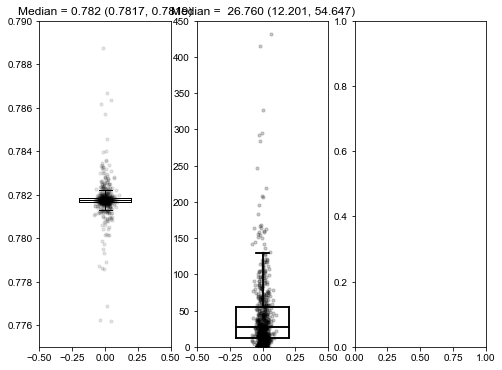

,Reference,Idx,R^2,Metabolite,Tesla,Localization,Subject,Filter,T2,T2_Pred,T2_Error,T2_Norm_Error,Actual,Prediction,Error
0,1996_cady_36,198,0.781806,GPC,2.4,PRESS,Human,0.0,498.4,213.863770,284.536230,1.393374,0.392554,0.146202,0.246352
1,2015_deelchand_73,302,0.782608,GPC,9.4,LASER,Rat,0.0,445.0,152.383512,292.616488,1.432943,0.346320,0.092973,0.253348
2,2015_deelchand_73,303,0.782452,GPC,9.4,LASER,Rat,1.0,523.0,228.154210,294.845790,1.443860,0.413853,0.158575,0.255278
3,2001_brooks_11,178,0.781841,GPC,1.5,STEAM,Human,0.0,556.0,229.787067,326.212933,1.597465,0.442424,0.159989,0.282435
4,2015_deelchand_73,555,0.782617,Myo,9.4,LASER,Rat,1.0,584.0,168.824620,415.175380,2.033114,0.466667,0.107207,0.359459
5,2015_deelchand_73,556,0.782772,Myo,9.4,LASER,Rat,1.0,600.0,168.761541,431.238459,2.111775,0.480519,0.107153,0.373367


In [24]:
df_error['T2_Pred'] = scaler.inverse_transform(df_error.Prediction.values.reshape(-1, 1)) 

rmses     = []
for ii in range(df_error.shape[0]):
    rmses.append(rmse(df_error.T2.values[ii], df_error.T2_Pred.values[ii]))
df_error['T2_Error'] = rmses
df_error['T2_Norm_Error'] = np.array(rmses)/np.mean(df_error['T2'])

R2_m   = np.median(df_error['R^2'])
R2_q1  = np.quantile(df_error['R^2'], .25)
R2_q3  = np.quantile(df_error['R^2'], .75)
R2_iqr = R2_q3-R2_q1
R2_q1_ = R2_q1 - (R2_iqr*1.75)
R2_q3_ = R2_q3 + (R2_iqr*1.75)

T2_m   = np.median(df_error['T2_Error'])
T2_q1  = np.quantile(df_error['T2_Error'], .25)
T2_q3  = np.quantile(df_error['T2_Error'], .75)
T2_iqr = T2_q3-T2_q1
T2_q1_ = T2_q1 - (T2_iqr*1.75)
T2_q3_ = T2_q3 + (T2_iqr*1.75)
T2_q1_ = 0

T2_m   = np.median(df_error['T2_Error'])
T2_q1  = np.quantile(df_error['T2_Error'], .25)
T2_q3  = np.quantile(df_error['T2_Error'], .75)
T2_iqr = T2_q3-T2_q1
T2_q1_ = T2_q1 - (T2_iqr*1.75)
T2_q3_ = T2_q3 + (T2_iqr*1.75)
T2_q1_ = 0

jitter  = np.random.normal(0,1,df_error.shape[0])
jitter *= .03

fig,ax = plt.subplots(1,3,figsize=(8,6))
ax     = np.ravel(ax)

ax[0].set_title('Median = {:5.3f} ({:6.4f}, {:6.4f})'.format(R2_m, R2_q1, R2_q3))
ax[0].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['R^2'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[0].set_ylim([0,1.0])
ax[0].plot([-0.20, 0.20], [R2_m  ,   R2_m], color='k', linewidth=1.0)
ax[0].plot([-0.20, 0.20], [R2_q1 ,  R2_q1], color='k', linewidth=1.0)
ax[0].plot([-0.20, 0.20], [R2_q3 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([ 0.20, 0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([-0.20,-0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([ 0.00, 0.00], [R2_q1_,  R2_q1], color='k', linewidth=1.0)
ax[0].plot([ 0.00, 0.00], [R2_q3_,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([-0.05, 0.05], [R2_q1_, R2_q1_], color='k', linewidth=1.0)
ax[0].plot([-0.05, 0.05], [R2_q3_, R2_q3_], color='k', linewidth=1.0)
ax[0].set_xlim([-0.5, 0.5])
ax[0].set_ylim([ 0.775, 0.79])

ax[1].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(T2_m, T2_q1, T2_q3))
ax[1].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['T2_Error'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[1].set_ylim([0,1.0])
ax[1].plot([-0.20, 0.20], [T2_m  ,   T2_m], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q1 ,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q3 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.20, 0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.20,-0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q1_,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q3_,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q1_, T2_q1_], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q3_, T2_q3_], color='k', linewidth=1.5)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([ 0.0, 450])


ax[1].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(T2_m, T2_q1, T2_q3))
ax[1].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['T2_Error'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[1].set_ylim([0,1.0])
ax[1].plot([-0.20, 0.20], [T2_m  ,   T2_m], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q1 ,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q3 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.20, 0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.20,-0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q1_,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q3_,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q1_, T2_q1_], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q3_, T2_q3_], color='k', linewidth=1.5)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([ 0.0, 450])
plt.show()

df_error_ = df_error[df_error.Error > .225].reset_index(drop=True)
idxs      = list(set(df_error_.Idx))

df_comb   = pd.DataFrame({})
for ii in range(len(idxs)):
    df_comb = pd.concat([df_comb, df_error_[df_error_.Idx == idxs[ii]].head(1)])

df_comb = df_comb.reset_index(drop=True)
df_comb['T2_Pred']    = scaler.inverse_transform(df_comb.Prediction.values.reshape(-1, 1)) 

display(df_comb.sort_values(by=['Error']).reset_index(drop=True)[['Reference', 'Idx', 'R^2', 'Metabolite', 'Tesla', 'Localization', 'Subject', 'Filter', 'T2', 'T2_Pred', 'T2_Error', 'T2_Norm_Error', 'Actual', 'Prediction', 'Error']])

### Leave 1 Out - Adjusted $R^2$ Histogram

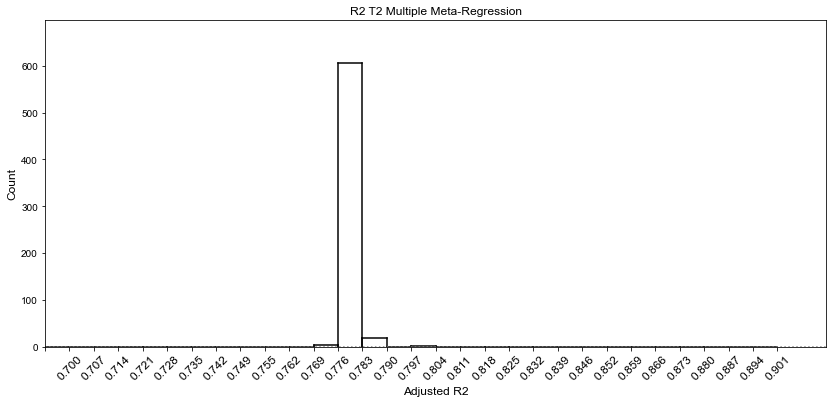

In [25]:

bin_low = .7
bin_hgh = .901
bins    = np.linspace(bin_low, bin_hgh, 30)
labels  = ['', '{:4.3f}'.format(bin_low)]

bcnts   = np.zeros([len(bins)])
for ii in range(1, len(bins)):
    for jj in range(df_error.shape[0]):
        if df_error['R^2'].values[jj] >= bins[ii-1] and df_error['R^2'].values[jj] < bins[ii]:
            bcnts[ii] +=1
    labels.append('{:4.3f}'.format(bins[ii]))
    
fig,ax  = plt.subplots(figsize=(14,6))
# ax.hist(bcnts, bins=30, color='royalblue', edgecolor='k', alpha=.75)

for ii in range(len(bins)):
    x1 = ii + 0.0
    x2 = ii + 1.0
    
    ax.plot([x1, x2], [bcnts[ii], bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x1, x1], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x2, x2], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    
    # if ii > 0:
    #     print('{:5d} {:5d} {:3d}'.format( int(bins[ii-1]), int(bins[ii]), int(bcnts[ii])))

ax.axhline(0.0, color='grey', linestyle='dotted')

ax.set_title('R2 T2 Multiple Meta-Regression', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Adjusted R2', fontsize=12)
ax.set_xticks([x for x in range(0, len(bins)+1)]) 
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_xlim([0, len(labels)+1])
ax.set_ylim([0, np.max(bcnts)*1.15])
plt.show()
# plt.savefig('Figure_T2_Model_R2_Histogram.pdf', dpi=300)

### Leave 1 Out - Error Histogram

431.23845857062014
629
 -450  -420   0
 -420  -390   0
 -390  -360   0
 -360  -330   0
 -330  -300   0
 -300  -270   0
 -270  -240   0
 -240  -210   0
 -210  -180   0
 -180  -150   0
 -150  -120   0
 -120   -90   2
  -90   -60  10
  -60   -30  64
  -30     0 177
    0    30 167
   30    60  81
   60    90  57
   90   120  37
  120   150  10
  150   180  12
  180   210   4
  210   240   1
  240   270   1
  270   300   3
  300   330   1
  330   360   0
  360   390   0
  390   420   1
  420   450   1


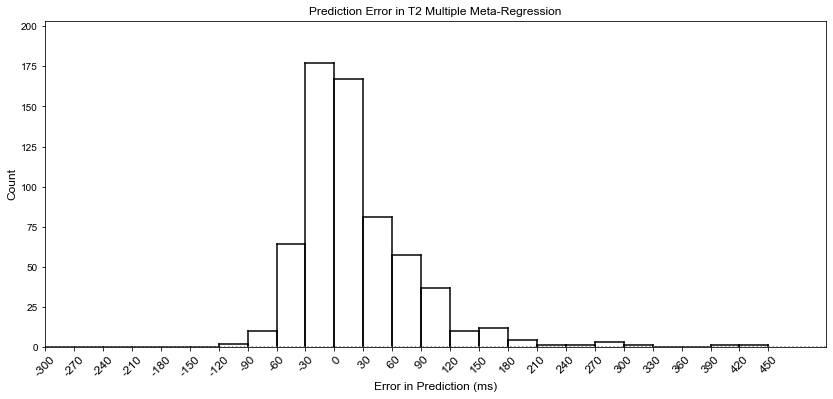

In [26]:
df_error['dist'] = (df_error.T2 - df_error.T2_Pred)
bin_low = np.min(df_error.dist)
bin_hgh = np.max(df_error.dist)
print(bin_hgh)
bin_low = -450
bin_hgh =  451
bins    = np.arange(bin_low, bin_hgh, 30)
labels  = ['', '{:3d}'.format(bin_low)]

bcnts   = np.zeros([len(bins)])
for ii in range(1, len(bins)):
    for jj in range(df_error.shape[0]):
        if df_error.dist.values[jj] >= bins[ii-1] and df_error.dist.values[jj] < bins[ii]:
            bcnts[ii] +=1
    labels.append('{:3d}'.format(int(bins[ii])))
    
print(df_error.shape[0])
fig,ax  = plt.subplots(figsize=(14,6))
# ax.hist(bcnts, bins=30, color='royalblue', edgecolor='k', alpha=.75)

for ii in range(len(bins)):
    x1 = ii + 0.0
    x2 = ii + 1.0
    
    ax.plot([x1, x2], [bcnts[ii], bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x1, x1], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x2, x2], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    
    if ii > 0:
        print('{:5d} {:5d} {:3d}'.format( int(bins[ii-1]), int(bins[ii]), int(bcnts[ii])))

ax.axhline(0.0, color='grey', linestyle='dotted')

ax.set_title('Prediction Error in T2 Multiple Meta-Regression', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Error in Prediction (ms)', fontsize=12)
ax.set_xticks([x for x in range(0, len(bins)+1)]) 
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_xlim([6, len(labels)+1])
ax.set_ylim([0, np.max(bcnts)*1.15])
plt.show()
# plt.savefig('Figure_T2_Prediction_Error_Histogram.pdf', dpi=300)

## Bubble Plot in Color All Data

0.48051948051948046


  0: NAA_CH3
161: GPC
309: Cre_CH3
471: Lac
479: Tau
493: Glu
528: Myo
559: NAAG_CH3
564: Cre_CH2
598: Gly
602: Asp
607: Gln
618: GSH
625: GABA


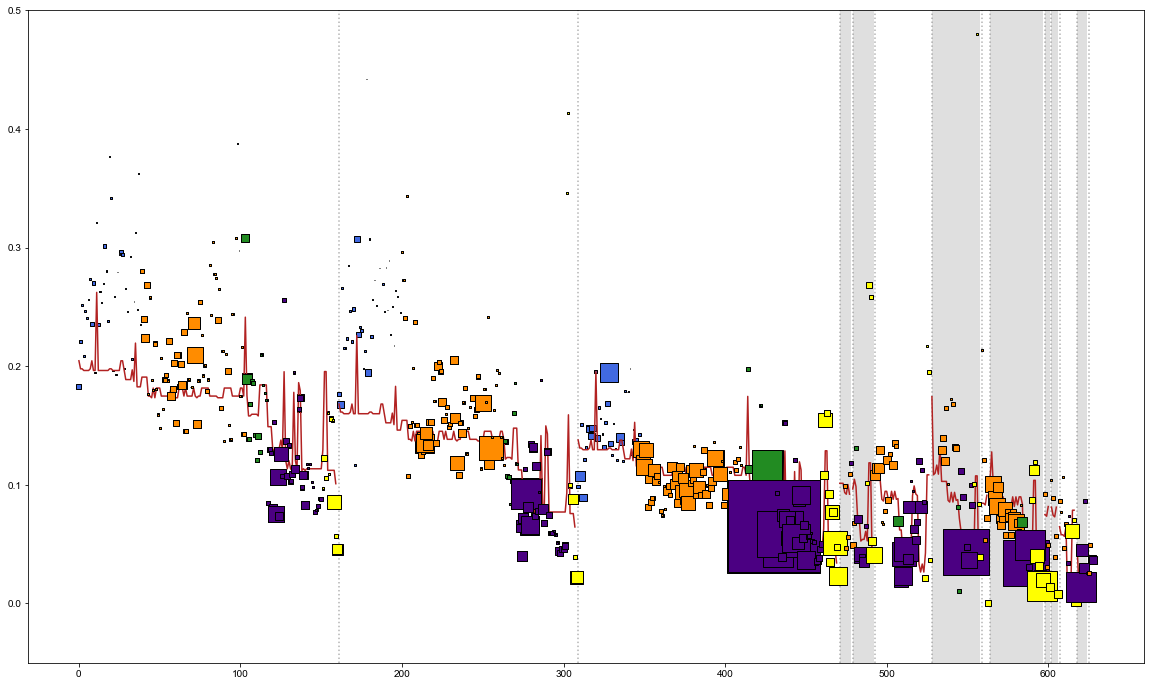

In [12]:
X_train   = copy.deepcopy(df_fit)                            # Input
W_train   = X_train.T2_Wgt.values                            # Weight
Y_train   = X_train.T2_u_.values                             # Output
X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
X_train   = sm.add_constant(X_train, has_constant='add')

wls_model = sm.WLS(Y_train, X_train, weights=W_train)        # Weighted Multiple Regression Model
wls_reslt = wls_model.fit()                                  # Fit the Model

fig, ax   = plt.subplots(figsize=(20, 12))

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

curr_met  = df_fit.T2_Met[0]
print(np.max(df_fit.T2_u_.values))

print('\n')
print('{:3d}: {}'.format(0, curr_met))

end_pnt = 471

# ax.scatter(np.arange(df_fit.T2_u_.shape[0]), df_fit.T2_u_.values, color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values, zorder=3)
ax.scatter(np.arange(end_pnt), df_fit.T2_u_.values[:end_pnt], color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[:end_pnt], zorder=3)

str_idx = 0
for ii in range(df_fit.shape[0]):
# for ii in range(472):
    if df_fit.T2_Met[ii] != curr_met:
        curr_met = df_fit.T2_Met[ii]
        ax.axvline(ii, color='k', linestyle='dotted', alpha=.3, zorder=0)
        print('{:3d}: {}'.format(ii, curr_met))
        ax.plot(np.arange(str_idx, ii-1), wls_reslt.fittedvalues[str_idx:ii-1], 'firebrick', zorder=3)
        if df_fit.Tesla[ii] == 3.0:
            ax.axvspan(str_idx, ii-1, facecolor='grey', alpha=0.25, zorder=1)
        str_idx = ii
    
    if df_fit.Tesla[ii] == 3.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='darkorange', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 3.0 and df_fit.Tesla[ii] < 5.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='forestgreen', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 3.0 and df_fit.Tesla[ii] == 7.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='indigo', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 7.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='yellow', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)

ax.set_ylim([-.05, .5])
plt.show()


## Weighted Least Squares Multiple Regression

In [27]:
X_train   = copy.deepcopy(df_fit)                            # Input
W_train   = X_train.T2_Wgt.values                            # Weight
Y_train   = X_train.T2_u_.values                             # Output
X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
X_train   = sm.add_constant(X_train, has_constant='add')

wls_model = sm.WLS(Y_train, X_train, weights=W_train)        # Weighted Multiple Regression Model
wls_reslt = wls_model.fit()                                  # Fit the Model


## More Unit Conversion

In [32]:
n100 = np.where(np.abs(linspace.values[:,1] - 100) == np.min(np.abs(linspace.values[:,1] - 100)) )[0]
n200 = np.where(np.abs(linspace.values[:,1] - 200) == np.min(np.abs(linspace.values[:,1] - 200)) )[0]
n300 = np.where(np.abs(linspace.values[:,1] - 300) == np.min(np.abs(linspace.values[:,1] - 300)) )[0]
n400 = np.where(np.abs(linspace.values[:,1] - 400) == np.min(np.abs(linspace.values[:,1] - 400)) )[0]
n500 = np.where(np.abs(linspace.values[:,1] - 500) == np.min(np.abs(linspace.values[:,1] - 500)) )[0]
n600 = np.where(np.abs(linspace.values[:,1] - 600) == np.min(np.abs(linspace.values[:,1] - 600)) )[0]

print('{:5d} {:7.4f} {:7.4f}'.format(n100[0], *linspace.values[n100,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n200[0], *linspace.values[n200,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n300[0], *linspace.values[n300,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n400[0], *linspace.values[n400,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n500[0], *linspace.values[n500,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n600[0], *linspace.values[n600,:][0]))

labels = np.array([0.047, 0.1342, 0.2208, 0.3074, 0.3939, 0.4805])

 2381  0.0476 100.0022
 6710  0.1342 200.0041
11039  0.2208 300.0060
15368  0.3074 400.0079
19697  0.3939 500.0098
24025  0.4805 599.9886


## Bubble Plots Gray Scale

Max Value:   0.481
  0  39
 39 103
103 117
117 151
151 161
161 200
200 264
264 272
272 302
302 309
309 348
348 414
414 427
427 461
461 471


<ipython-input-34-e0c3b1eff316>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'white'
<ipython-input-34-e0c3b1eff316>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'darkorange'
<ipython-input-34-e0c3b1eff316>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'forestgreen'
<ipython-input-34-e0c3b1eff316>:32: SettingWithCopyWarning: 
A value is

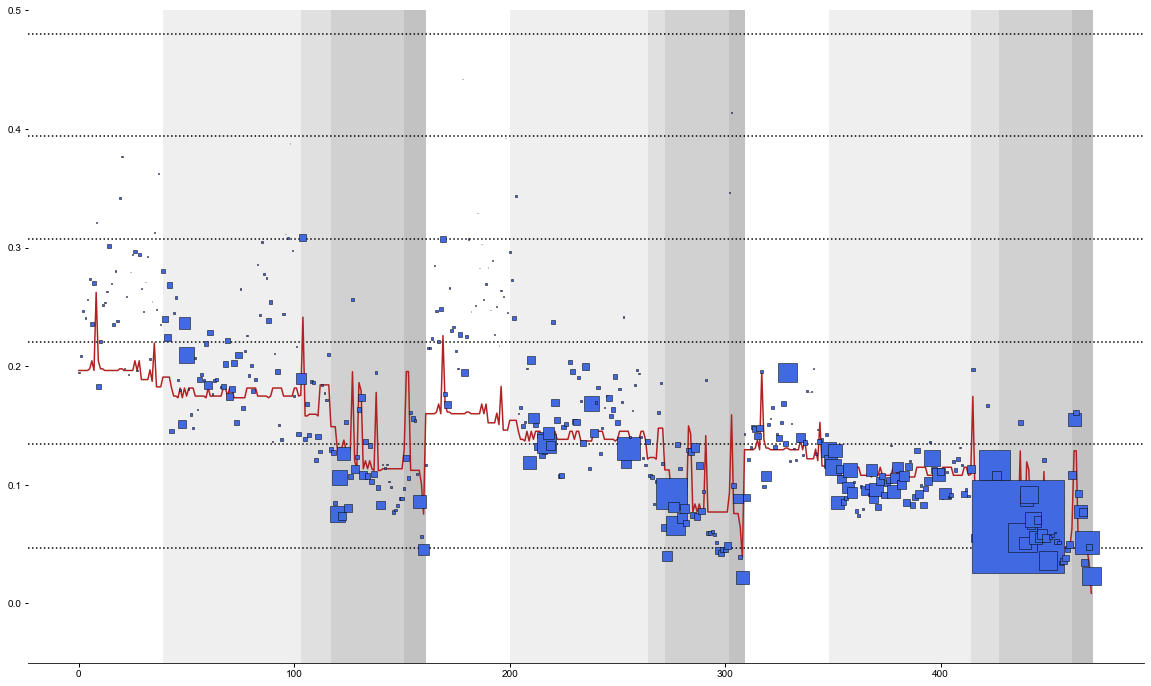

In [34]:

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

t2_met_ord= ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
included  = ['NAA_CH3', 'GPC', 'Cre_CH3',]
# included  = copy.deepcopy(t2_met_ord)

print('Max Value: {:7.3f}'.format(np.max(df_fit.T2_u_.values)))

fig, ax   = plt.subplots(figsize=(20, 12))
ax.plot(np.arange(471), wls_reslt.fittedvalues[:471], 'firebrick', zorder=3)
# ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', zorder=3)

met_idx = 0
for ii in range(len(included)):
    df_fit_t2 = df_fit[df_fit.T2_Met.str.contains(included[ii])].reset_index(drop=True)
    # display(df_fit_t2.head(3))

    end_idx   = met_idx + df_fit_t2.shape[0]
    xaxis     = np.arange(met_idx, end_idx)
    ax.scatter(xaxis, df_fit_t2.T2_u_.values, color='royalblue', edgecolors='k', linewidth=0.5, marker='s', s=df_fit_t2.Area_Weight.values, zorder=5)
    
    df_fit_t2['BackColor'] = df_fit_t2.Tesla.astype(str)
    for jj in range(df_fit_t2.shape[0]):
        if df_fit_t2.Tesla[jj] < 3.0:
            df_fit_t2['BackColor'][jj] = 'white'
        elif df_fit_t2.Tesla[jj] == 3.0:
            df_fit_t2['BackColor'][jj] = 'darkorange'
        elif df_fit_t2.Tesla[jj] > 3.0 and df_fit_t2.Tesla[jj] < 7.0:
            df_fit_t2['BackColor'][jj] = 'forestgreen'
        elif df_fit_t2.Tesla[jj] == 7.0:
            df_fit_t2['BackColor'][jj] = 'indigo'
        elif df_fit_t2.Tesla[jj] > 9.0:
            df_fit_t2['BackColor'][jj] = 'lightgray'

    colors  = ['white', 'darkorange', 'forestgreen', 'indigo', 'lightgray']
    alphas  = [0.0, .12, .24, .36, .480]
    str_idx = 0 + met_idx
    for jj in range(len(colors)):
        
        df_fit_color = df_fit_t2[df_fit_t2.BackColor.str.contains(colors[jj])].reset_index(drop=True)
        end_idx      = str_idx+df_fit_color.shape[0]
        
        print('{:3d} {:3d}'.format(str_idx, end_idx))
        ax.axvspan(str_idx, end_idx, facecolor='gray', alpha=alphas[jj], zorder=1)
        str_idx = end_idx
    met_idx = end_idx

for ii in range(labels.shape[0]):
    ax.axhline(labels[ii], color='k', linestyle='dotted')
    
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

# ax.set_xlim([-.1, 471])
ax.set_ylim([-0.05, .5])
plt.savefig('Figure_T2_Model_Partial.pdf', dpi=300, transparent=True)
# plt.show()


## Weighted Least Squares Multiple Regression?

In [40]:
print(wls_reslt.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            WLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     119.4
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          7.20e-191
Time:                        05:46:21   Log-Likelihood:                 1028.6
No. Observations:                 629   AIC:                            -2017.
Df Residuals:                     609   BIC:                            -1928.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2508      0.006     38.589      0.0

## Subset

Max Value:   0.481

  0: GABA
  0  39
 39 103
103 117
117 151
151 161
161 200
200 264
264 272
272 302
302 309
309 348
348 414
414 427
427 461
461 471


<ipython-input-24-691270019bdb>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'white'
<ipython-input-24-691270019bdb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'darkorange'
<ipython-input-24-691270019bdb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'forestgreen'
<ipython-input-24-691270019bdb>:33: SettingWithCopyWarning: 
A value is

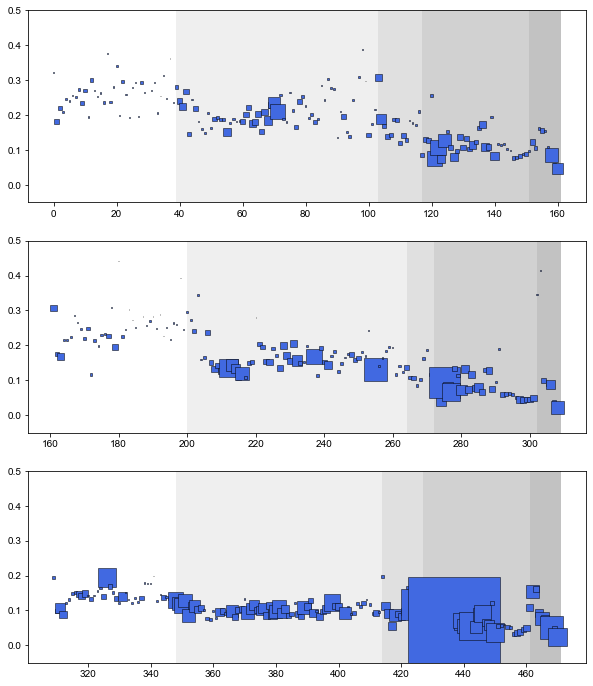

In [24]:

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

t2_met_ord= ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
included  = ['NAA_CH3', 'GPC', 'Cre_CH3',]
# included  = copy.deepcopy(t2_met_ord)

print('Max Value: {:7.3f}'.format(np.max(df_fit.T2_u_.values)))
print('\n{:3d}: {}'.format(0, curr_met))

fig, ax   = plt.subplots(3,1,figsize=(10, 12))
# ax.plot(np.arange(471), wls_reslt.fittedvalues[:471], 'firebrick', zorder=3)
# ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', zorder=3)

met_idx = 0
for ii in range(len(included)):
    df_fit_t2 = df_fit[df_fit.T2_Met.str.contains(included[ii])].reset_index(drop=True)
    # display(df_fit_t2.head(3))

    end_idx   = met_idx + df_fit_t2.shape[0]
    xaxis     = np.arange(met_idx, end_idx)
    ax[ii].scatter(xaxis, df_fit_t2.T2_u_.values, color='royalblue', edgecolors='k', linewidth=0.5, marker='s', s=df_fit_t2.Area_Weight.values, zorder=5)
    
    df_fit_t2['BackColor'] = df_fit_t2.Tesla.astype(str)
    for jj in range(df_fit_t2.shape[0]):
        if df_fit_t2.Tesla[jj] < 3.0:
            df_fit_t2['BackColor'][jj] = 'white'
        elif df_fit_t2.Tesla[jj] == 3.0:
            df_fit_t2['BackColor'][jj] = 'darkorange'
        elif df_fit_t2.Tesla[jj] > 3.0 and df_fit_t2.Tesla[jj] < 7.0:
            df_fit_t2['BackColor'][jj] = 'forestgreen'
        elif df_fit_t2.Tesla[jj] == 7.0:
            df_fit_t2['BackColor'][jj] = 'indigo'
        elif df_fit_t2.Tesla[jj] > 9.0:
            df_fit_t2['BackColor'][jj] = 'lightgray'

    colors  = ['white', 'darkorange', 'forestgreen', 'indigo', 'lightgray']
    alphas  = [0.0, .12, .24, .36, .480]
    str_idx = 0 + met_idx
    for jj in range(len(colors)):
        
        df_fit_color = df_fit_t2[df_fit_t2.BackColor.str.contains(colors[jj])].reset_index(drop=True)
        end_idx      = str_idx+df_fit_color.shape[0]
        
        print('{:3d} {:3d}'.format(str_idx, end_idx))
        ax[ii].axvspan(str_idx, end_idx, facecolor='gray', alpha=alphas[jj], zorder=1)
        str_idx = end_idx
    met_idx = end_idx

    # ax[ii].set_xlim([-.1, 471])
    ax[ii].set_ylim([-.05, .5])
# plt.savefig('Figure_T2_Model.pdf', dpi=300)
plt.show()


## Bubble Plot - Leave 1 Out

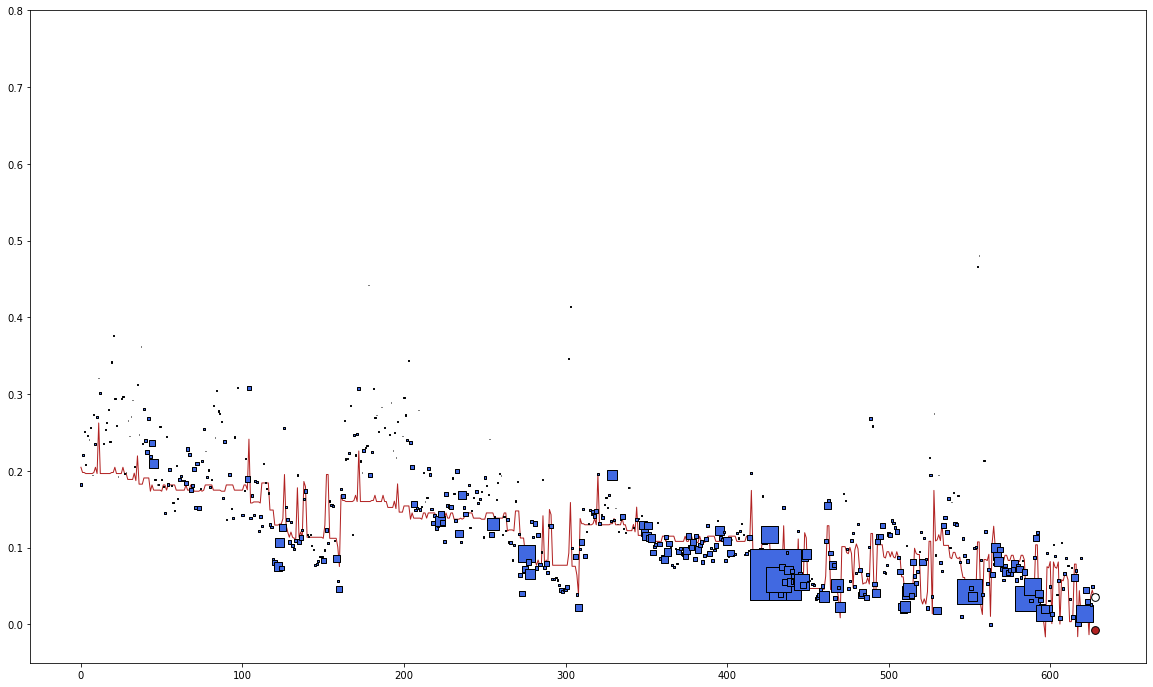

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', linewidth=1.0, zorder=0)

df_fit['Area_Weight'] = df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)
ax.scatter(np.arange(df_fit.T2_u_.shape[0]), df_fit.T2_u_.values, color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values*15000, zorder=3)
ax.scatter(test, Y_test, color='white'    , edgecolors='k', s=60, zorder=1000)
ax.scatter(test, np.array(prd_reslt)      , color='firebrick', edgecolors='k', s=60, zorder=1000)

ax.set_ylim([-.05,.8])
plt.show()